In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import torchvision.transforms as transforms
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
number_of_imgs_to_load_foreach_class = 5

In [3]:
def extract_images(folder_path):
    image_dict = {}

    image_files = glob.glob(os.path.join(folder_path, '*.png'))

    for file_path in image_files:
        file_name = os.path.basename(file_path)
        image_name = file_name.split('_')[0]

        if image_name not in image_dict:
            image_dict[image_name] = []

        image_dict[image_name].append(file_path)

    images_list = []
    classes_list = []
    selected_dict = {}
    for image_name, image_paths in image_dict.items():
        selected_dict[image_name] = image_paths[:number_of_imgs_to_load_foreach_class]
        images_list.extend(image_paths[:number_of_imgs_to_load_foreach_class])
        classes_list.extend([image_name] * len(image_paths[:number_of_imgs_to_load_foreach_class]))

    return images_list, classes_list, selected_dict

In [4]:
images, images_classes, images_dict = extract_images('../data/img/')

for i in range(len(images)):
    img = images[i]
    img = img[:11] + '/' + img[12:]
    images[i] = img

len(images), images

(27,
 ['../data/img/break_did_31656_vid_63422.png',
  '../data/img/break_did_34558_vid_67835.png',
  '../data/img/bubble_did_10072_vid_18745.png',
  '../data/img/bubble_did_10144_vid_18856.png',
  '../data/img/bubble_did_10480_vid_19437.png',
  '../data/img/bubble_did_10511_vid_19490.png',
  '../data/img/bubble_did_10551_vid_19592.png',
  '../data/img/dirt_did_10413_vid_19322.png',
  '../data/img/dirt_did_1081_vid_2023.png',
  '../data/img/dirt_did_1082_vid_2025.png',
  '../data/img/dirt_did_1083_vid_2027.png',
  '../data/img/dirt_did_10848_vid_20075.png',
  '../data/img/mark_did_31945_vid_63809.png',
  '../data/img/mark_did_32196_vid_64192.png',
  '../data/img/mark_did_32203_vid_64211.png',
  '../data/img/mark_did_7400_vid_13504.png',
  '../data/img/mark_did_7404_vid_13512.png',
  '../data/img/point_did_10251_vid_19050.png',
  '../data/img/point_did_10272_vid_19081.png',
  '../data/img/point_did_10366_vid_19226.png',
  '../data/img/point_did_10414_vid_19324.png',
  '../data/img/point_

In [5]:
masks, masks_classes, masks_dict = extract_images('../data/label/')

for i in range(len(masks)):
    img = masks[i]
    img = img[:13] + '/' + img[14:]
    masks[i] = img

len(masks), masks

(27,
 ['../data/label/break_did_31656_vid_63422_mask.png',
  '../data/label/break_did_34558_vid_67835_mask.png',
  '../data/label/bubble_did_10072_vid_18745_mask.png',
  '../data/label/bubble_did_10144_vid_18856_mask.png',
  '../data/label/bubble_did_10480_vid_19437_mask.png',
  '../data/label/bubble_did_10511_vid_19490_mask.png',
  '../data/label/bubble_did_10551_vid_19592_mask.png',
  '../data/label/dirt_did_10413_vid_19322_mask.png',
  '../data/label/dirt_did_1081_vid_2023_mask.png',
  '../data/label/dirt_did_1082_vid_2025_mask.png',
  '../data/label/dirt_did_1083_vid_2027_mask.png',
  '../data/label/dirt_did_10848_vid_20075_mask.png',
  '../data/label/mark_did_31945_vid_63809_mask.png',
  '../data/label/mark_did_32196_vid_64192_mask.png',
  '../data/label/mark_did_32203_vid_64211_mask.png',
  '../data/label/mark_did_7400_vid_13504_mask.png',
  '../data/label/mark_did_7404_vid_13512_mask.png',
  '../data/label/point_did_10251_vid_19050_mask.png',
  '../data/label/point_did_10272_vid

In [6]:
images = [cv2.imread(img) for img in images]
masks = [cv2.imread(img) for img in masks]

In [7]:
len(images), len(masks), len(images) == len(masks)

(27, 27, True)

In [8]:
len(images_classes), len(masks_classes), len(images_classes) == len(masks_classes), len(set(images_classes)), len(set(masks_classes)), len(set(images_classes)) == len(set(masks_classes))

(27, 27, True, 6, 6, True)

In [9]:
classes = set(images_classes).union(set(masks_classes))
len(classes), classes

(6, {'break', 'bubble', 'dirt', 'mark', 'point', 'scratch'})

In [10]:
def plot_comparison(title1, title2, img1, img2):
    fig = plt.figure(figsize=(6, 4))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)

    plt.imshow(img1)
    plt.axis('off')
    plt.title(title1)

    fig.add_subplot(rows, columns, 2)

    plt.imshow(img2)
    plt.axis('off')
    plt.title(title2)

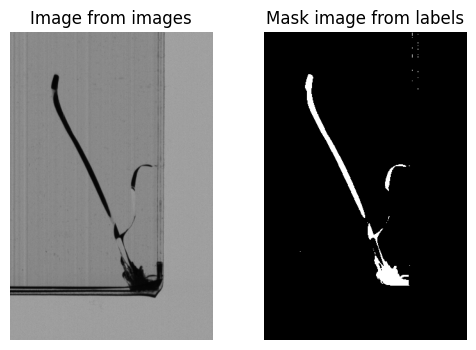

In [11]:
plot_comparison("Image from images", "Mask image from labels", images[0], masks[0])

In [12]:
def augment_image(image):
    augmented_images = []

    augmented_images.append(image)

    flipped_x = cv2.flip(image, 0)
    augmented_images.append(flipped_x)

    flipped_y = cv2.flip(image, 1)
    augmented_images.append(flipped_y)

    rotated_180 = cv2.rotate(image, cv2.ROTATE_180)
    augmented_images.append(rotated_180)

    return augmented_images

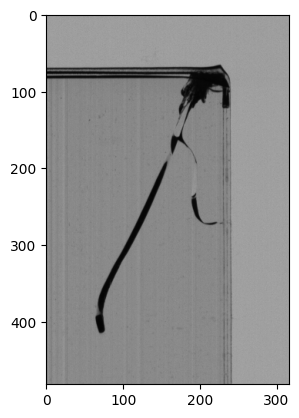

In [13]:
ex = augment_image(cv2.imread(images_dict['break'][0]))
plt.imshow(ex[0])
plt.imshow(ex[1])
# plt.imshow(ex[2])
# plt.imshow(ex[3])

In [14]:
def pil_to_cv2(image_pil):
    image_np = np.array(image_pil)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    return image_bgr

def resize_image(image, label, output_size):
    default_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(output_size),
        transforms.Resize((output_size, output_size))
    ])

    break_mark_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((output_size, output_size))
    ])

    resized_image = break_mark_transform(image) if label == 'break' or label == 'mark' else default_transform(image)
    resized_image = pil_to_cv2(resized_image)

    return resized_image

(60, 60, 3)


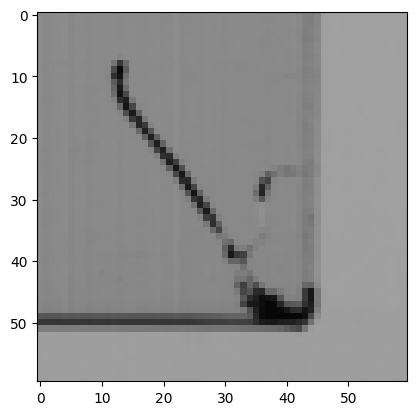

In [15]:
ex = resize_image(cv2.imread(images_dict['break'][0]), 'break', 60)
print(ex.shape)
plt.imshow(ex)

In [16]:
for key in images_dict.keys():
    images_dict[key] = [img[:11] + '/' + img[12:] for img in images_dict[key]]
    images_dict[key] = [aug for img in images_dict[key] for aug in augment_image(cv2.imread(img))]
    images_dict[key] = [resize_image(img, key, 60) for img in images_dict[key]]

for key in masks_dict.keys():
    masks_dict[key] = [img[:13] + '/' + img[14:] for img in masks_dict[key]]
    masks_dict[key] = [aug for img in masks_dict[key] for aug in augment_image(cv2.imread(img))]
    masks_dict[key] = [resize_image(img, key, 60) for img in masks_dict[key]]

target_classes = []
for cls in images_classes:
    target_classes.extend([cls] * 4)

In [17]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    print('K:',K)

    for cls in K:
        datax_cls = np.random.permutation(datax[cls])[:(n_support + n_query)]
        sample.append(datax_cls)

    sample = np.array(sample)
    sample = torch.from_numpy(sample)

    sample = sample.permute(0, 1, 4, 2, 3)

    return({
        'images': sample,
        'n_way': n_way,
        'n_support': n_support,
        'n_query': n_query
    })

In [18]:
sample_example = extract_sample(6, 4, 4, images_dict, images_classes)
sample_example['images'].shape, sample_example

K: ['break' 'point' 'mark' 'dirt' 'bubble' 'scratch']


(torch.Size([6, 8, 3, 60, 60]),
 {'images': tensor([[[[[158, 157, 158,  ..., 158, 158, 158],
             [158, 158, 158,  ..., 158, 158, 158],
             [158, 158, 158,  ..., 158, 158, 158],
             ...,
             [161, 160, 161,  ..., 138, 136, 139],
             [161, 160, 160,  ..., 138, 136, 139],
             [160, 160, 161,  ..., 139, 136, 138]],
  
            [[158, 157, 158,  ..., 158, 158, 158],
             [158, 158, 158,  ..., 158, 158, 158],
             [158, 158, 158,  ..., 158, 158, 158],
             ...,
             [161, 160, 161,  ..., 138, 136, 139],
             [161, 160, 160,  ..., 138, 136, 139],
             [160, 160, 161,  ..., 139, 136, 138]],
  
            [[158, 157, 158,  ..., 158, 158, 158],
             [158, 158, 158,  ..., 158, 158, 158],
             [158, 158, 158,  ..., 158, 158, 158],
             ...,
             [161, 160, 161,  ..., 138, 136, 139],
             [161, 160, 160,  ..., 138, 136, 139],
             [160, 160, 161, 

In [19]:
def display_sample(sample):
    sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
    out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
    plt.figure(figsize = (16,7))
    plt.imshow(out.permute(1, 2, 0))

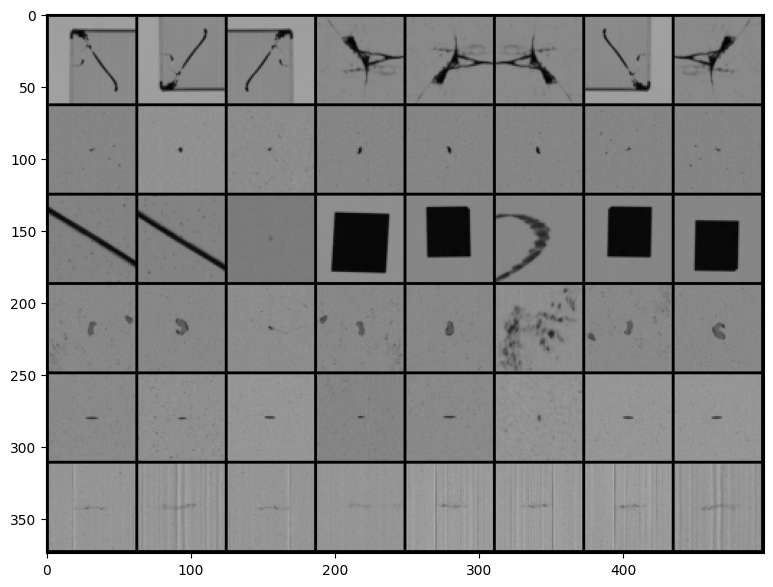

In [20]:
display_sample(sample_example['images'])

In [21]:
def euclidean_dist(x, y):
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

In [22]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet, self).__init__()
        self.encoder = encoder#.cuda()

    def set_forward_loss(self, sample):
        """
        Computes loss, accuracy and output for classification task
        Args:
            sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
        Returns:
            torch.Tensor: shape(2), loss, accuracy and y_hat
        """
        sample_images = sample['images']#.cuda()
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        x_support = sample_images[:, :n_support]
        x_query = sample_images[:, n_support:]

        #target indices are 0 ... n_way-1
        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
        target_inds = Variable(target_inds, requires_grad=False)
        target_inds = target_inds#.cuda()

        #encode images of the support and the query set
        x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                        x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
        
        z = self.encoder.forward(x.float())
        z_dim = z.size(-1) 
        z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
        z_query = z[n_way*n_support:]

        #compute distances
        dists = euclidean_dist(z_query, z_proto)

        #compute probabilities
        log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)

        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        _, y_hat = log_p_y.max(2)
        acc_val = torch.eq(y_hat.squeeze(), target_inds.squeeze()).float().mean()

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat.squeeze(),
            'y_true': target_inds.squeeze()
        }

In [23]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )
    
  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )
    
  return ProtoNet(encoder)

In [24]:
def  split_train_test(data, percentage = 3/4):
    train_x = {}
    test_x = {}
    for key in data.keys():
        dim = len(data[key])
        train_x[key] = data[key][:int(len(data[key])*percentage)]
        test_x[key] = data[key][-int(dim - int(dim*percentage)):]

    train_y = []
    test_y = []
    for key in data.keys():
        dim = len(data[key])
        train_y.extend([key] * int(dim*percentage))
        test_y.extend([key] * int(dim - int(dim*percentage)))
    
    return train_x, train_y, test_x, test_y

In [25]:
train_x, train_y, test_x, test_y = split_train_test(images_dict)

In [26]:
for k in images_dict.keys():
    print(len(images_dict[k]))
print('-----')
for k in train_x.keys():
    print(len(train_x[k]))
print('-----')
for k in test_x.keys():
    print(len(test_x[k]))

8
20
20
20
20
20
-----
6
15
15
15
15
15
-----
2
5
5
5
5
5


# Train

In [27]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [28]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
    """
    Trains the protonet
    Args:
        model
        optimizer
        train_x (np.array): images of training set
        train_y(np.array): labels of training set
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
        max_epoch (int): max epochs to train on
        epoch_size (int): episodes per epoch
    """
    #divide the learning rate by 2 at each epoch, as suggested in paper
    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0 #epochs done so far
    stop = False #status to know when to stop

    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0

        for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()
            epoch_loss = running_loss / epoch_size
            epoch_acc = running_acc / epoch_size
            print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
            epoch += 1
            scheduler.step()

In [29]:
%%time

model = load_protonet_conv(
    x_dim=(3,60,60),
    hid_dim=64,
    z_dim=64,
)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 3
n_support = 2
n_query = 1

max_epoch = 10
epoch_size = 50

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

C:\Users\matte\AppData\Local\Temp\ipykernel_9124\2888097730.py:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/50 [00:00<?, ?it/s]

K: ['break' 'point' 'dirt']
Epoch 1 -- Loss: 0.0000 Acc: 0.0200
K: ['dirt' 'mark' 'bubble']
Epoch 2 -- Loss: 0.0772 Acc: 0.0333
K: ['break' 'dirt' 'bubble']
Epoch 3 -- Loss: 0.0772 Acc: 0.0533
K: ['dirt' 'mark' 'point']
Epoch 4 -- Loss: 0.1347 Acc: 0.0667
K: ['scratch' 'point' 'break']
Epoch 5 -- Loss: 0.1347 Acc: 0.0867
K: ['dirt' 'mark' 'break']
Epoch 6 -- Loss: 0.3356 Acc: 0.1000
K: ['point' 'dirt' 'scratch']
Epoch 7 -- Loss: 0.3359 Acc: 0.1200
K: ['break' 'bubble' 'dirt']
Epoch 8 -- Loss: 0.3359 Acc: 0.1400
K: ['break' 'dirt' 'point']
Epoch 9 -- Loss: 0.3371 Acc: 0.1600
K: ['dirt' 'mark' 'point']
Epoch 10 -- Loss: 1.0387 Acc: 0.1733
K: ['break' 'point' 'dirt']
Epoch 11 -- Loss: 1.0387 Acc: 0.1933
K: ['scratch' 'mark' 'dirt']
Epoch 12 -- Loss: 1.0387 Acc: 0.2133
K: ['dirt' 'bubble' 'point']
Epoch 13 -- Loss: 1.7997 Acc: 0.2200
K: ['point' 'break' 'scratch']
Epoch 14 -- Loss: 1.7997 Acc: 0.2400
K: ['point' 'scratch' 'bubble']
Epoch 15 -- Loss: 1.7997 Acc: 0.2600
K: ['point' 'scratch'

# Test

In [30]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    """
    Tests the protonet
    Args:
        model: trained model
        test_x (np.array): images of testing set
        test_y (np.array): labels of testing set
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
        test_episode (int): number of episodes to test on
    """
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [31]:
n_way = 3
n_support = 1
n_query = 1

test_episode = 50

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)
     

C:\Users\matte\AppData\Local\Temp\ipykernel_9124\3119107161.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(test_episode):


  0%|          | 0/50 [00:00<?, ?it/s]

K: ['scratch' 'dirt' 'point']
K: ['break' 'dirt' 'mark']
K: ['scratch' 'dirt' 'point']
K: ['bubble' 'dirt' 'point']
K: ['scratch' 'bubble' 'dirt']
K: ['bubble' 'mark' 'dirt']
K: ['mark' 'scratch' 'bubble']
K: ['point' 'break' 'dirt']
K: ['bubble' 'point' 'scratch']
K: ['dirt' 'mark' 'break']
K: ['point' 'bubble' 'scratch']
K: ['break' 'scratch' 'point']
K: ['break' 'mark' 'bubble']
K: ['mark' 'bubble' 'scratch']
K: ['point' 'scratch' 'mark']
K: ['point' 'scratch' 'mark']
K: ['scratch' 'mark' 'bubble']
K: ['mark' 'break' 'scratch']
K: ['scratch' 'dirt' 'mark']
K: ['bubble' 'dirt' 'point']
K: ['dirt' 'scratch' 'mark']
K: ['dirt' 'break' 'mark']
K: ['break' 'point' 'dirt']
K: ['dirt' 'scratch' 'point']
K: ['mark' 'point' 'scratch']
K: ['break' 'mark' 'bubble']
K: ['bubble' 'break' 'dirt']
K: ['point' 'scratch' 'dirt']
K: ['dirt' 'mark' 'scratch']
K: ['bubble' 'scratch' 'point']
K: ['point' 'dirt' 'scratch']
K: ['scratch' 'dirt' 'break']
K: ['mark' 'point' 'break']
K: ['break' 'point' 'mar

# test on specific sample

K: ['mark' 'break' 'bubble']


{'loss': -0.0,
 'acc': 1.0,
 'y_hat': tensor([0, 1, 2]),
 'y_true': tensor([0, 1, 2])}

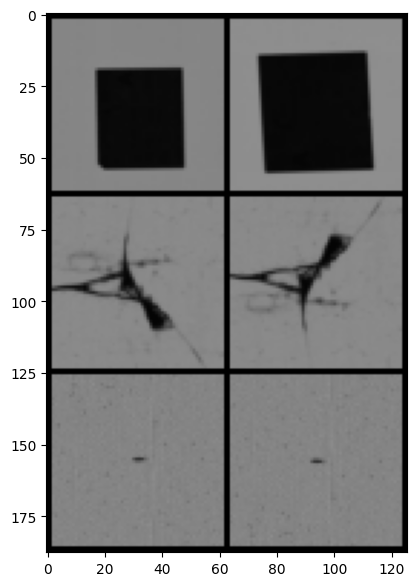

In [32]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])
my_loss, my_output = model.set_forward_loss(my_sample)
my_output